UPLOAD FILE

First of all we need to upload the file that will be analyzed to the collab work environment

In [0]:
from google.colab import files
# Remember to upload the groun truth  (ground_truths.py)

uploaded = files.upload()

Saving ground_truths.py to ground_truths.py


# IMPORTS

Importing required packages

In [0]:
import os
from scipy.io import wavfile
import numpy as npy
import matplotlib.pyplot as plot
import aifc
from scipy import signal
from skimage.feature import peak_local_max
from numpy import fft
import matplotlib.collections as collections
import librosa
from termcolor import colored
try:
    from ground_truths import get_ground_truth
except ModuleNotFoundError:
    print('Upload the ground_truths.py file')

# CLASS DEFINITIONS

We define a FileReader(), a PCPExtractor(), and a ChordMatcher() classes, with their respective methods

In [0]:
class FileReader:
		
  def read_data(self, filename):
    
    extension = os.path.splitext(filename)[-1]
    if extension == '.wav':
      fs, data = wavfile.read(filename)
      data = data[:, 0] # Left channel
      #data = (data[:, 0] + data[:, 1]) / 2
    elif extension == '.aif':
      obj = aifc.open(filename, 'r')
      nframes = obj.getnframes()
      strsig = obj.readframes(nframes)
      data = npy.array(npy.frombuffer(strsig, npy.short).byteswap())
      fs = obj.getframerate()
      obj.close()
    else:
      raise Exception('Audio format not supported')
    return data, fs


class PCPExtractor:
	
  def __init__(self, window_size, fs, fref=261.63, min_dist_maxima_spectrum=5, min_freq_threshold=100):
    self.window_size=window_size
    self.fs=fs
    self.fref=fref
    self.min_dist_maxima_spectrum = min_dist_maxima_spectrum
    self.min_freq_threshold = min_freq_threshold
    self.NOTES = [
      'do',   'do#',  're',   're#',  'mi',   'fa',
      'fa#',  'sol',  'sol#', 'la',   'la#',  'si'
    ]
		
  def compute_fft(self, signal):
    spectrum = abs(fft.fft(signal))
    return spectrum

  def filter_fft(self, spectrum):
    indexes = peak_local_max(spectrum, min_distance=self.min_dist_maxima_spectrum)
    filtered_spectrum = npy.zeros(len(spectrum))
    for i in indexes:
      real_f_hz = self.fs * i / self.window_size
      if real_f_hz > self.min_freq_threshold:
        filtered_spectrum[i] = spectrum[i]
    return filtered_spectrum

  def calculate_PCP(self, filtered_spectrum, normalize_values=True):
    mapping = npy.zeros(int(self.window_size/2)).astype(int)
    mapping[0] = -1
    PCP = npy.zeros(12)

    for x in range(1, int(self.window_size/2)):
      real_f_hz = self.fs * x / self.window_size
      mapping[x] = int(
          npy.mod(round(12 * npy.log2(real_f_hz / self.fref)), 12)
      )
      PCP[mapping[x]] += npy.square(filtered_spectrum[x])

    if normalize_values:
      PCP = PCP / max(PCP)
    
    PCP = dict(zip(self.NOTES, PCP))
    return PCP
		
  def get_PCP(self, windowed_data):
    pcp = self.calculate_PCP(self.filter_fft(self.compute_fft(windowed_data)))
    return pcp


class ChordMatcher:

  def __init__(self, threshold=1.8, method = 'threshold'):
    self.threshold = threshold
    self.method = method
    notes = [
      'do',   'do#',  're',    're#',   'mi',   'fa',
      'fa#',  'sol',  'sol#',  'la',    'la#',  'si'
    ]
    self.CHORDS = {
      'Do Maj':   dict(zip(notes, [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
      'Do# Maj':  dict(zip(notes, [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])),
      'Re Maj':   dict(zip(notes, [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])),
      'Re# Maj':  dict(zip(notes, [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])),
      'Mi Maj':   dict(zip(notes, [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])),
      'Fa Maj':   dict(zip(notes, [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])),
      'Fa# Maj':  dict(zip(notes, [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])),
      'Sol Maj':  dict(zip(notes, [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])),
      'Sol# Maj': dict(zip(notes, [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])),
      'La Maj':   dict(zip(notes, [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])),
      'La# Maj':  dict(zip(notes, [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0])),
      'Si Maj':   dict(zip(notes, [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])),

      'Do Min':   dict(zip(notes, [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
      'Do# Min':  dict(zip(notes, [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])),
      'Re Min':   dict(zip(notes, [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0])),
      'Re# Min':  dict(zip(notes, [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])),
      'Mi Min':   dict(zip(notes, [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])),
      'Fa Min':   dict(zip(notes, [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])),
      'Fa# Min':  dict(zip(notes, [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])),
      'Sol Min':  dict(zip(notes, [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])),
      'Sol# Min': dict(zip(notes, [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])),
      'La Min':   dict(zip(notes, [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])),
      'La# Min':  dict(zip(notes, [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])),
      'Si Min':   dict(zip(notes, [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])),
    }
		
  def compute_correlation(self, PCP):
    correlation = {}
    for chord, pcp_dict in self.CHORDS.items():
      correlation[chord] = 0
      for note, pcp_value in PCP.items():
        correlation[chord] += pcp_value * pcp_dict[note]
    
    return correlation
		
  def find_chord(self, correlation):
    sorted_correlation = sorted(
      correlation.items(), key=lambda kv: kv[1], reverse=True
    )
    chord = None
    if self.method == 'threshold':
      THRESHOLD = self.threshold
      max_value = sorted_correlation[0][1]
      if max_value > THRESHOLD:
        chord = sorted_correlation[0][0]
    elif self.method == 'difference':
      THRESHOLD = self.threshold
      ratio = sorted_correlation[0][1]/sorted_correlation[1][1]
      if ratio > THRESHOLD:
        chord = sorted_correlation[0][0]

    return chord, max_value
    
  def get_chord(self, PCP, silence):
    if silence:
      return None
    else:
      chord, max_value = self.find_chord(self.compute_correlation(PCP))
      return chord

# FUNCTION DEFINITIONS

Here we define the auxiliar functions that will be used during the execution, but are not tied to any class.

In [0]:
def enwindow_data(data, window_size, delay, window_function_name='cosine'):
    """Sets the window_data attribute"""

    windowed_data = data[delay:delay+window_size]

    if window_function_name == 'cosine':
        window_function = signal.windows.cosine(window_size)
    elif window_function_name == 'hamming':
        window_function = signal.hamming(window_size)
    else:
        # TODO: try with other functions
        raise Exception('To be implemented')

    return windowed_data * window_function


#Define a function for merging chords if needed
#Currently done explicitly in run code, so not needed

def get_power(windowed_data, fs):
  # f, Pxx_spec = signal.periodogram(windowed_data, fs, 'flattop', scaling='spectrum')
  # power = npy.sqrt(Pxx_spec.max())
  power = 0
  for i in range(0, len(windowed_data)):
    power += windowed_data[i]**2
  power = power / len(windowed_data)
  return power
  

def final_plot(results):
  fig, ax = plot.subplots(dpi=150)
  ax.set_title('Data with found chords')
  ax.plot(range(int(npy.size(data))), data)

  y_positions = [max(data)/2, min(data)/2]
  current_y_idx = 0
  x_offset = 0
  for second, chord, is_ok in results:
    coord = second * fs
    if is_ok:
      plot.axvline(x=coord, color='g')
      bbox = {'facecolor': 'green', 'alpha': 0.5, 'pad': 1}
      ax.text(coord + x_offset, 0, chord,
              rotation='vertical', bbox=bbox, fontsize=7)
    else:
      plot.axvline(x=coord, color='r')
      bbox = {'facecolor': 'red', 'alpha': 0.5, 'pad': 1}
      ax.text(coord + x_offset, 0, chord,
              rotation='vertical', bbox=bbox, fontsize=7)
    current_y_idx = (current_y_idx + 1) % 2



# PARAMETERS

We initialize the variables that will be used as parameters for our code

In [0]:
#filename = 'love-me-do-mono.wav'
filename = 'baby_its_you.wav'
window_size = 1024*8
MARGIN = 0.5         #seconds
#power_threshold = 2

ground_truth = get_ground_truth(filename)

# EXECUTION

We instantiate an object of each class and call the appropriate methods in order to make our algorithm work

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


avg power: 19742740.612012625
0.9	Sol Maj	OK
13.8	Do Maj	OK
18.1	Sol Maj	OK
30.3	Sol# Min	NO OK
32.4	Mi Min	OK
32.5	Mi Maj	NO OK
33.0	Mi Min	OK
34.9	La Min	OK
41.0	Mi Min	NO OK
41.1	Mi Maj	OK
41.4	Mi Min	NO OK
41.7	Mi Maj	OK
43.6	Do Maj	OK
46.0	Re Maj	OK
51.7	Mi Maj	NO OK
52.5	Mi Min	OK
54.3	Re Min	NO OK
54.6	Sol Maj	OK
56.7	Mi Maj	NO OK
57.5	Mi Min	OK
57.7	Mi Maj	NO OK
59.2	Do Maj	OK
59.7	Sol Maj	NO OK
66.7	Do Maj	OK
68.4	Sol Min	NO OK
70.8	Sol Maj	OK
76.1	Mi Maj	NO OK
76.8	Sol# Min	NO OK
77.4	Mi Maj	NO OK
78.9	Mi Min	OK
79.4	La Min	OK
92.2	Re Maj	OK
94.7	Sol Maj	NO OK
96.6	Mi Maj	OK
98.2	Mi Min	OK
103.6	Do Maj	OK
109.3	Si Min	NO OK
115.8	Sol Maj	OK
117.3	Si Min	NO OK
117.5	Sol Maj	OK
117.9	Si Min	NO OK
118.1	Sol Maj	OK
125.9	La Min	OK
128.1	Do Maj	NO OK
130.9	Mi Maj	NO OK
132.3	Mi Min	OK
133.7	Do Maj	OK
135.8	Re Maj	OK
141.8	Mi Maj	OK
145.8	Mi Min	OK
145.9	Mi Maj	NO OK
148.0	Sol Maj	OK
Precision: 0.6153846153846154
Recall: 0.5925925925925926


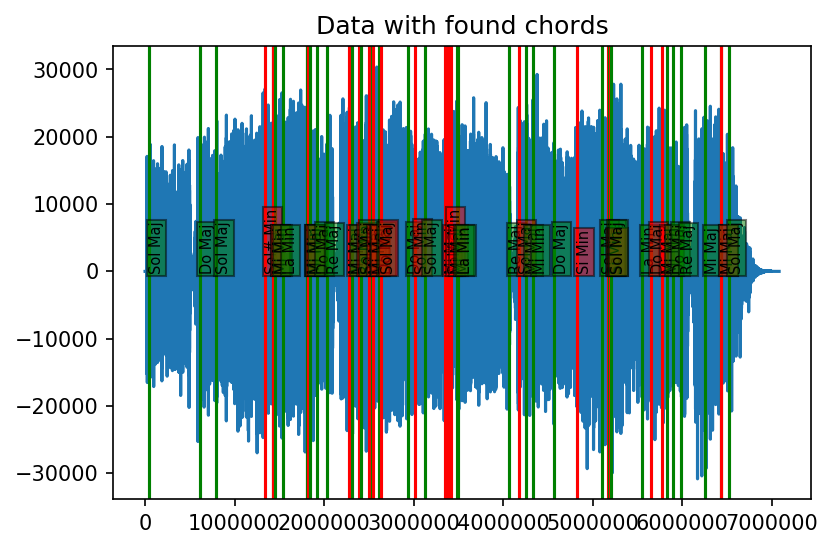

In [23]:
file_reader = FileReader()

data, fs = file_reader.read_data(filename)

pcp_extractor = PCPExtractor(
  window_size=window_size,
  fs=fs,
  min_freq_threshold=250
)

chord_matcher=ChordMatcher(
  threshold=2.2,
)

chords = []
results = []
silence=True
avg_power=get_power(data, fs)
print('avg power: '+ str(avg_power))                             ###############


for delay in range(0, data.size-window_size, int(window_size/2)):
  windowed_data=enwindow_data(data, window_size, delay=delay)
  power = get_power(windowed_data, fs)
  if (power>0.5*avg_power):                                      ###############
    silence=False
    PCP=pcp_extractor.get_PCP(windowed_data)
  else:
    silence=True
    PCP=None
  #print(str(power) + '   ' + str(silence))                 ####################
  chord =chord_matcher.get_chord(PCP,silence)

  if chord:
    try:
      last_chord = chords[-1][1]
      if last_chord == chord:
        continue
    except IndexError:
      pass
    second = delay / fs
    chords.append((round(second, 1), chord))

true_positives = 0
false_negatives = 0
false_positives = 0
for second, chord in chords:
  is_ok = False
  for good_chord, sec_from, sec_to in ground_truth:
    if ((second >= (sec_from - MARGIN)) and
    (second <= (sec_to + MARGIN)) and
    (chord == good_chord)):
      is_ok = True
      break
  if is_ok:
    results.append((second, chord, True))
    true_positives += 1
    print('\t'.join([str(second), chord, 'OK']))            ####################
  else:
    results.append((second, chord, False))
    false_positives += 1
    print('\t'.join([str(second), chord, 'NO OK']))	        ####################

false_negatives = len(ground_truth) - true_positives
final_plot(results)	
recall = true_positives / len(ground_truth)
precision = true_positives / (true_positives + false_positives)
print(f'Precision: {precision}')
print(f'Recall: {recall}')